# Strands Nova Quickstart Guide

This notebook provides a comprehensive introduction to using Amazon Nova models with the Strands Agents SDK.

## What You'll Learn

1. Installation and setup
2. Basic usage with the Strands Agent
3. Streaming responses
4. Tool calling / function calling
5. Multi-modal input (images)

## Prerequisites

- Python 3.10+
- A Nova API key (get one at [https://nova.amazon.com/dev-apis](https://nova.amazon.com/dev-apis))

## 1. Installation

Install the required packages:

In [1]:
%pip install strands-agents strands-nova python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install git+https://github.com/nova-ai-api/strands-nova

## 2. Setup and Basic Usage

First, let's set up our API key. You can either:
- Set it as an environment variable: `export NOVA_API_KEY=your-key-here`
- Use a `.env` file
- Pass it directly to the model

In [5]:
from dotenv import load_dotenv
from strands import Agent
from strands_nova import NovaAPIModel

# Load environment variables from .env file
load_dotenv()

# Initialize the Nova model
model = NovaAPIModel(
    model_id="nova-pro-v1",
    stream=False,  # We'll use streaming in the next example
)

# Create an agent with the model
agent = Agent(
    model=model,
    system_prompt="You are a helpful assistant."
)

print("✓ Agent initialized successfully!")

✓ Agent initialized successfully!


### Simple Conversation

Let's have a simple conversation with the agent:

In [6]:
# Ask a simple question
response = agent("What are the seven colors of the rainbow?")

print("Question: What are the seven colors of the rainbow?")
print(f"\nResponse: {response.message}")
print(f"\nToken Usage: {response.metrics.accumulated_usage}")

The seven colors of the rainbow, traditionally recognized and often remembered by the acronym ROYGBIV, are:

1. **Red**
2. **Orange**
3. **Yellow**
4. **Green**
5. **Blue**
6. **Indigo**
7. **Violet**

These colors appear in a rainbow due to the dispersion of light as it passes through water droplets in the atmosphere. Each color corresponds to a different wavelength of light, with red having the longest wavelength and violet the shortest.Question: What are the seven colors of the rainbow?

Response: {'role': 'assistant', 'content': [{'text': 'The seven colors of the rainbow, traditionally recognized and often remembered by the acronym ROYGBIV, are:\n\n1. **Red**\n2. **Orange**\n3. **Yellow**\n4. **Green**\n5. **Blue**\n6. **Indigo**\n7. **Violet**\n\nThese colors appear in a rainbow due to the dispersion of light as it passes through water droplets in the atmosphere. Each color corresponds to a different wavelength of light, with red having the longest wavelength and violet the shorte

## 3. Streaming Responses

Streaming allows you to receive the model's response in real-time as it's being generated. This is great for user experience in interactive applications.

In [7]:
# Create a streaming model
streaming_model = NovaAPIModel(
    model_id="nova-pro-v1",
    params={
        "temperature": 0.7,
        "max_tokens": 512,
    },
    stream=True,
)

# Create an agent with the streaming model
streaming_agent = Agent(
    model=streaming_model,
    system_prompt="You are a helpful assistant."
)

async def stream_example():
    print("Question: Tell me a short story about a robot learning to paint.\n")
    print("Response: ", end="", flush=True)
    
    async for event in streaming_agent.stream_async(
        "Tell me a short story about a robot learning to paint."
    ):
        if "data" in event:
            print(event["data"], end="", flush=True)
        elif "result" in event:
            result = event["result"]
            if hasattr(result, "metrics") and result.metrics:
                print(f"\n\nToken Usage: {result.metrics.accumulated_usage}")
    
    print("\n")

# Run the async function
await stream_example()

Question: Tell me a short story about a robot learning to paint.

Response: OnceOnce upon a time upon a time, in, in a small, a small, sun sunlit workshop,lit workshop, there lived there lived a curious a curious robot named Art robot named Artieie. Art. Artie was designedie was designed for various for various tasks, but he had tasks, but he had a special a special fascination fascination with human with human creativity, creativity, especially painting especially painting. His. His metallic metallic eyes eyes would would light light up whenever up whenever he saw a he saw a brushstroke or brushstroke or a splash a splash of color of color.

One day, Art.

One day, Artie's creatorie's creator, a kind-hearted, a kind-hearted artist named Clara artist named Clara, noticed, noticed his his interest interest. She decided to teach. She decided to teach Artie the Artie the art of painting. With a art of painting. With a gentle smile, she gentle smile, she placed a placed a blank blank canva

## 4. Tool Calling (Function Calling)

Tool calling allows the model to use external functions to accomplish tasks. This is powerful for creating agents that can interact with APIs, databases, or perform calculations.

In [9]:
from strands import tool

# Define custom tools
@tool
def get_weather(location: str) -> str:
    """Get the current weather for a location.
    
    Args:
        location: The city or location to get weather for
    
    Returns:
        Weather information as a string
    """
    # This is a dummy implementation
    # In a real application, you'd call a weather API
    return f"The weather in {location} is sunny with a temperature of 72°F."

@tool
def calculate(expression: str) -> str:
    """Evaluate a mathematical expression.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., "2 + 2", "10 * 5")
    
    Returns:
        The result of the calculation
    """
    try:
        result = eval(expression)
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error calculating {expression}: {str(e)}"

# Create an agent with tools
tool_model = NovaAPIModel(
    model_id="nova-pro-v1",
    params={
        "temperature": 0.1,
        "max_tokens": 512,
    },
    stream=False,
)

tool_agent = Agent(
    model=tool_model,
    tools=[get_weather, calculate],
    system_prompt="You are a helpful assistant with access to weather and calculation tools."
)

# Test the agent with a query that requires tool use
response = tool_agent("What's the weather in Paris? Also, what is 15 times 23?")
print(f"Response: {response.message}")
print(f"\nToken Usage: {response.metrics.accumulated_usage}")


Tool #1: get_weather

Tool #2: calculate
The weather in Paris is sunny with a temperature of 72°F. Additionally, the result of 15 times 23 is 345.Response: {'role': 'assistant', 'content': [{'text': 'The weather in Paris is sunny with a temperature of 72°F. Additionally, the result of 15 times 23 is 345.'}]}

Token Usage: {'inputTokens': 1146, 'outputTokens': 113, 'totalTokens': 1259}


### Using Pre-built Tools

You can also use pre-built tools from the `strands-tools` package:

In [10]:
%pip install strands-agents-tools

Note: you may need to restart the kernel to use updated packages.


In [11]:
from strands_tools import calculator

# Create an agent with the pre-built calculator tool
calculator_agent = Agent(
    model=tool_model,
    tools=[calculator],
    system_prompt="You are a helpful math assistant."
)

response = calculator_agent("What is the square root of 144 plus 25?")
print(f"Response: {response.message}")


Tool #1: calculator


╭────────────────────────────────────────────── Calculation Result ───────────────────────────────────────────────╮
│                                                                                                                 │
│  ╭───────────┬─────────────────────╮                                                                            │
│  │ Operation │ Evaluate Expression │                                                                            │
│  │ Input     │ sqrt(144) + 25      │                                                                            │
│  │ Result    │ 37                  │                                                                            │
│  ╰───────────┴─────────────────────╯                                                                            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

The square root of 144 plus 25 is 37.Response: {'role': 'assistant', 'content': [{'text': 'The square root of 144 plus 25 is 37.'}]}


## 5. Multi-Modal Input (Images)

Nova models support multi-modal inputs, including images. Let's see how to send an image to the model.

### Create a Sample Image

First, let's create a simple colored image for testing:

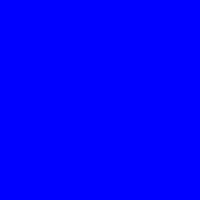

✓ Created a blue test image


In [12]:
from PIL import Image
import io

# Create a simple blue square image
image = Image.new('RGB', (200, 200), color='blue')

# Save to bytes
img_byte_arr = io.BytesIO()
image.save(img_byte_arr, format='PNG')
image_bytes = img_byte_arr.getvalue()

# Display the image
display(image)
print("✓ Created a blue test image")

### Send Image to Model

In [13]:
# Create a model for vision tasks
vision_model = NovaAPIModel(
    model_id="nova-pro-v1",
    stream=False,
)

vision_agent = Agent(
    model=vision_model,
    system_prompt="You are a helpful vision assistant that can analyze images."
)

# Create content with text and image
content = [
    {"text": "What color is this image? Please be specific."},
    {
        "image": {
            "format": "png",
            "source": {
                "bytes": image_bytes,
            },
        },
    },
]

response = vision_agent(content)
print(f"Question: What color is this image?")
print(f"\nResponse: {response.message}")

The image is a solid, uniform color with no visible details or variations. It appears to be a flat, single-color image with no discernible objects or patterns. The color of the image is a deep, rich blue, often described as royal blue or navy blue. It is a vibrant and saturated shade of blue, with no hints of other colors or gradients. The blue color is consistent throughout the entire image, creating a visually striking and eye-catching effect.Question: What color is this image?

Response: {'role': 'assistant', 'content': [{'text': 'The image is a solid, uniform color with no visible details or variations. It appears to be a flat, single-color image with no discernible objects or patterns. The color of the image is a deep, rich blue, often described as royal blue or navy blue. It is a vibrant and saturated shade of blue, with no hints of other colors or gradients. The blue color is consistent throughout the entire image, creating a visually striking and eye-catching effect.'}]}


### Using Real Images

You can also load images from files:

In [14]:
# Example with a file (adjust path as needed)

with open("yellow.png", "rb") as f:
    image_bytes = f.read()

content = [
    {"text": "Describe the color you see in this image."},
    {
        "image": {
            "format": "png",
            "source": {
                "bytes": image_bytes,
            },
        },
    },
]

response = vision_agent(content)
print(response.message)

The image is a solid, uniform color with no visible details or variations. It appears to be a flat, single-color image with no discernible objects or patterns. The color of the image is a bright, vibrant yellow, often described as neon yellow or electric yellow. It is a bold and eye-catching shade of yellow, with no hints of other colors or gradients. The yellow color is consistent throughout the entire image, creating a visually striking and attention-grabbing effect.{'role': 'assistant', 'content': [{'text': 'The image is a solid, uniform color with no visible details or variations. It appears to be a flat, single-color image with no discernible objects or patterns. The color of the image is a bright, vibrant yellow, often described as neon yellow or electric yellow. It is a bold and eye-catching shade of yellow, with no hints of other colors or gradients. The yellow color is consistent throughout the entire image, creating a visually striking and attention-grabbing effect.'}]}


### Error Handling

In [15]:
from strands.types.exceptions import (
    ContextWindowOverflowException,
    ModelThrottledException
)

async def safe_agent_call(agent, prompt):
    """Safely call an agent with error handling."""
    try:
        response = agent(prompt)
        return response.message
    except ContextWindowOverflowException as e:
        print(f"Context window exceeded: {e}")
        print("Try reducing message history or input size.")
        return None
    except ModelThrottledException as e:
        print(f"Rate limited: {e}")
        print("Please wait and try again.")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None

# Example usage
result = await safe_agent_call(agent, "What is the capital of France?")
if result:
    print(f"Result: {result}")

The capital of France is Paris. 

Paris is not only the political and economic hub of France but also a global center for finance, commerce, fashion, science, and the arts. It is renowned for its rich history, culture, and iconic landmarks. Some of the most famous attractions in Paris include:

- **The Eiffel Tower**: An iconic symbol of France, this iron lattice tower was built in 1889 for the World’s Fair.
- **The Louvre Museum**: One of the world's largest and most visited art museums, housing thousands of works of art including the Mona Lisa and the Venus de Milo.
- **Notre-Dame Cathedral**: A medieval Catholic cathedral on the Île de la Cité, famous for its Gothic architecture and intricate facade.
- **The Champs-Élysées**: A prestigious avenue known for its theaters, cafes, and luxury shops, leading to the Arc de Triomphe.
- **Montmartre**: A historic district known for its artistic history, the Basilica of the Sacré-Cœur, and the Moulin Rouge cabaret.

Paris is also celebrated f